# CIFAR-10 이미지 생성하기

1. 이미지 데이터의 shape이 (32, 32, 3)이므로 생성자, 판별자 모델의 입출력 shape 및 모델 구조를 수정해야 함
2. RGB 3채널의 컬러이미지 변경 -> 시각화 과정에서 고려해야 함

In [4]:
import os # 디렉토리 관리
import glob # 디렉토리 관리
import time # 작동 시간 관리

import PIL
import imageio # 이미지와 GIF를 다루는 데 쓰임
import numpy as np # 행렬연산
import tensorflow as tf # 신경망
from tensorflow.keras import layers # 신경망 레이어
from IPython import display # 학습내용 출력
import matplotlib.pyplot as plt # 데이터 시각화
%matplotlib inline 
# 쥬피터에서 바로 이미지 보여줌

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## 1. 데이터 셋

- CIFAR-10 데이터셋은 tf.keras 안에 있는 datasets에 포함되어 있다
- 50000개 학습데이터, 10000개 테스트 데이터를 합쳐준다

In [28]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()# _ 를 쓰면 해당 데이터(y_train, y_test) 무시

dataset = np.concatenate((train_x, test_x)) # 두 데이터 합치기(axis = 0) 아래에 붙임

dataset.shape

(60000, 32, 32, 3)

### 데이터 시각화
- 학습데이터를 랜덤으로 시각화 한다

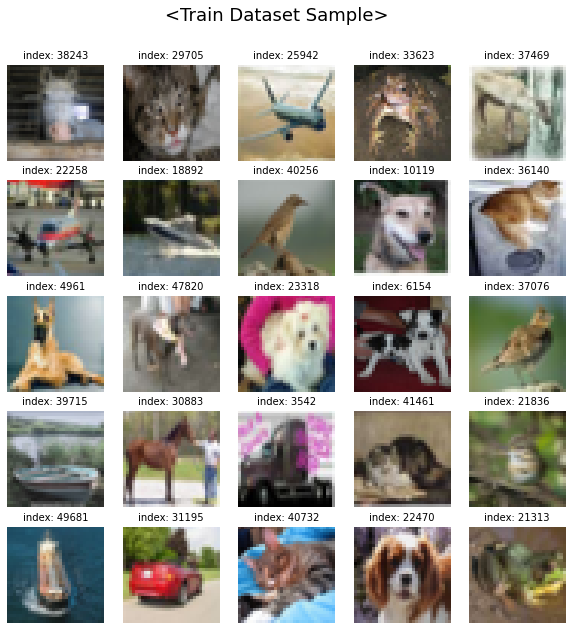

In [29]:
plt.figure(figsize=(10, 10)) # 이미지의 전체 프레임의 크기
plt.suptitle("<Train Dataset Sample>", fontsize = 18)
plt.subplots_adjust(top = 0.9)

for i in range(25):
    plt.subplot(5, 5, i+1) # 여러 개의 이미지를 한 번에 띄우고 싶을 때 plt.subplot(row, col, index)
    random_index = np.random.randint(1, 50000) # train data만 출력
    plt.imshow(train_x[random_index].reshape(32, 32, 3)) # 사이즈 맞게 reshape
    plt.title(f'index: {random_index}', size = 10) #이미지에 제목으로 라벨 값 넣기
    plt.axis('off') #불필요한 축을 지우기
plt.show()

### 데이터 전처리
- Zero-mean 정규화하여 중간값을 0으로 맞추고, 메모리를 절약한다

In [30]:
# 픽셀의 최대, 최소값 확인
print("max pixel:", dataset.max())
print("min pixel:", dataset.min())

max pixel: 255
min pixel: 0


In [31]:
dataset = (dataset - 127.5) / 127.5 # 데이터를 [-1, 1]로 정규화

print("max pixel:", dataset.max())
print("min pixel:", dataset.min())

max pixel: 1.0
min pixel: -1.0


이제 텐서플로우의 Dataset을 이용하여 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.(여기서는 60000으로 설정)

- mini batch : 적절한 배치 사이즈로 잘라서 학습을 진행
많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리기 때문에 배치 사이즈를 지정하여 학습을 진행한다.

- tf.data.Dataset.from_tensor_slices() 함수
리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.

- shuffle() 함수
데이터셋을 잘 섞어준다.

In [32]:
BUFFER_SIZE, BATCH_SIZE = 50000, 256
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 모델

이번에 사용할 모델은 GAN(Generative Adversarial Network) 모델인데, 아래 두가지 네트워크로 구성되어 있다.

1. 생성자(Generator)
아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해 냅니다. 즉, 무에서 유를 창조하는 것과 같은 역할을 합니다.

2. 판별자(Discriminator)
기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real 인지, Fake 인지에 대한 판단 정도를 실숫값으로 출력합니다.

예시로 GAN 모델의 목적이 진짜 지폐와 구분될 수 없는 위조지폐를 만드는 것이라면, 위 두가지 네트워크는 위조지폐를 만들어 내는 팀(Generative Model)과 위조 지폐범을 잡아내는 경찰(Discriminative Model)로 비유할 수 있다. 이렇게 서로 경쟁하듯 이루어진 모델의 구조 덕분에 이름에 "Adversarial(적대적인)"이 들어갔다.



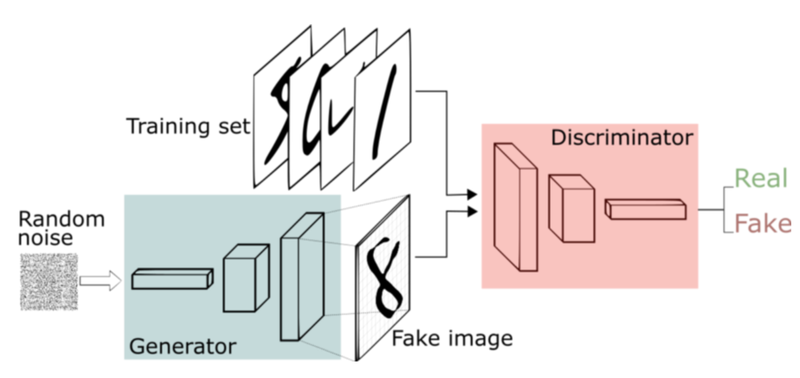

출처 : https://arxiv.org/pdf/1406.2661.pdf


___  


그리고 오늘은 GAN 중 특히 합성곱 층(Convolutional Layer)으로 이루어진 DCGAN (Deep Convolutional GAN)이라는 딥러닝 모델을 사용한다. DCGAN은 아래와 같은 Input과 Output을 받는다.

Input : 100 random numbers drawn from a uniform distribution 
(called as a code, or latent variables)

Output : an image (in this case 64x64x3 images)


* GAN 외에도 Variational Autoencoders (VAEs), Autoregressive models (ex. Pixel RNN) 이라는 생성 모델링 기법이 있다. (아래 출처를 참고)

출처 : https://openai.com/blog/generative-models/

## 1. 생성자(Generator) 구현하기

- Alec Radford 와 Luke Metz가 제시한 모델을 중심으로 구현하였다.

- 생성자는 100 크기의 벡터를 입력으로 받아 최종적으로 32크기의 3채널 이미지를 출력한다.

- $4 * 4 * 1,024$ 크기의 밀집층 이후 세 개의 Convolution 레이어를 추가하였다.

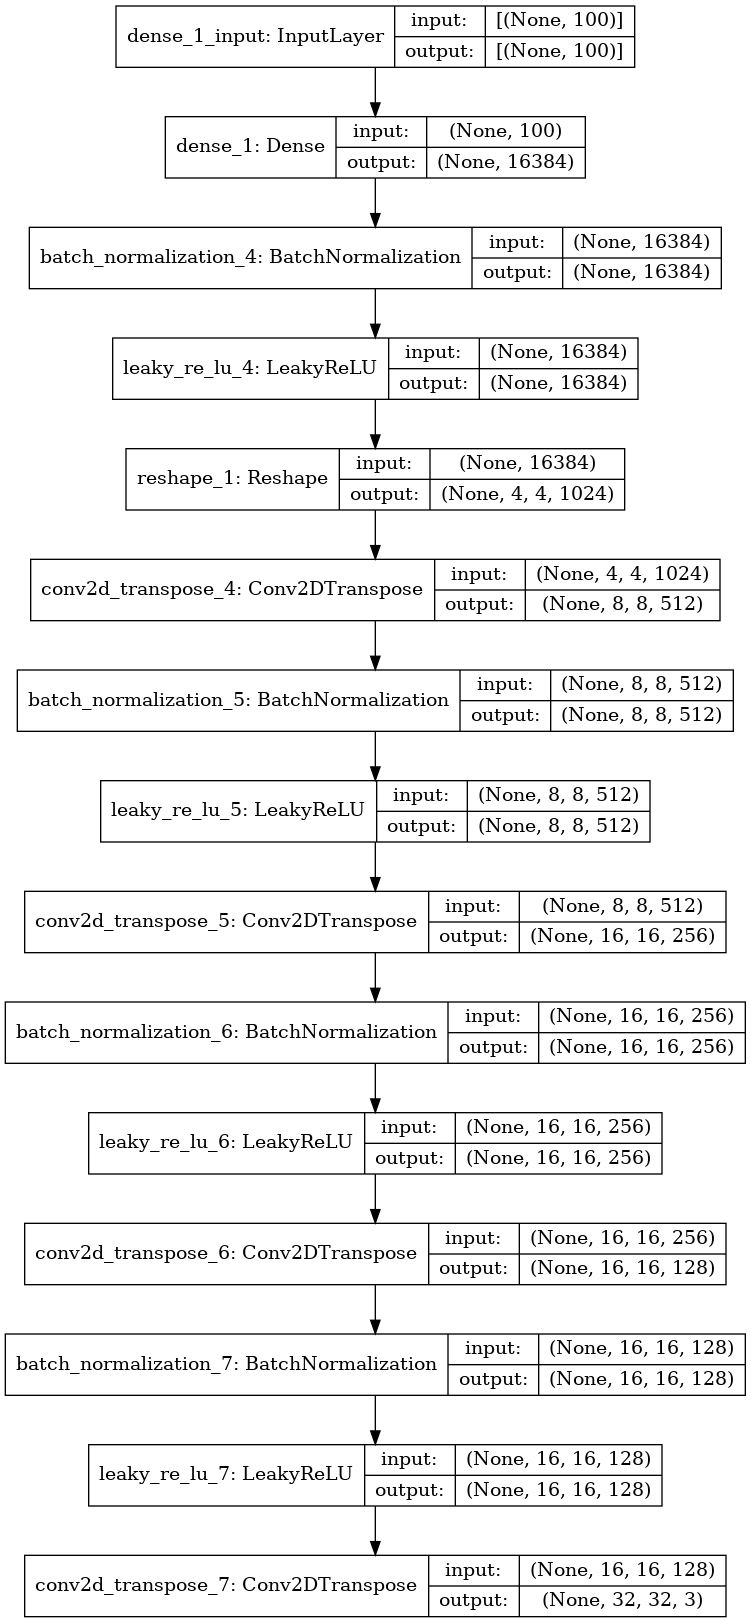

In [33]:
# Keras Sequential API를 활용
# Tensorflow 2.0 Tutorial의 DCGAN 구현을 기반으로 상세한 설명을 추가
# make_generator_model이라는 함수를 만들어서 언제든 생성자를 생성

def make_generator_model():

    # Start
    model = tf.keras.Sequential() # tf.keras.Sequential()로 모델을 시작

    # First: Dense layer
    model.add(layers.Dense(4 * 4* 1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 1024)))

    # Third: Conv2DTranspose layer_가장 중요한 레이어
    # 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
    # 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 
    # (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나감
    # 최종 사이즈인 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일
    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(
        3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'
    ))
    #-1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위해서 tanh 사용

    return model

In [34]:
# 모델 세부내용 출력해보기
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_7 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 512)        

In [35]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보기
# tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들수 있다

noise = tf.random.normal([1, 100])

In [36]:
# 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 
# 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성된다

# Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 
# training=False을 주어야 올바른 결과를 얻을 수 있다

generated_image = generator(noise, training=False) # 학습하는 중이 아니니 training=False를 설정
generated_image.shape

TensorShape([1, 32, 32, 3])

첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻이다.

## 2. 판별자(Discriminator)구현하기

판별자는 각 이미지 별로 '진짜라고 판단하는 정도' 값을 출력해야 한다.
(32,32,3) 크기의 이미지를 입력하고, 단 하나의 숫자(진짜라고 판단하는 정도)가 출력된다.

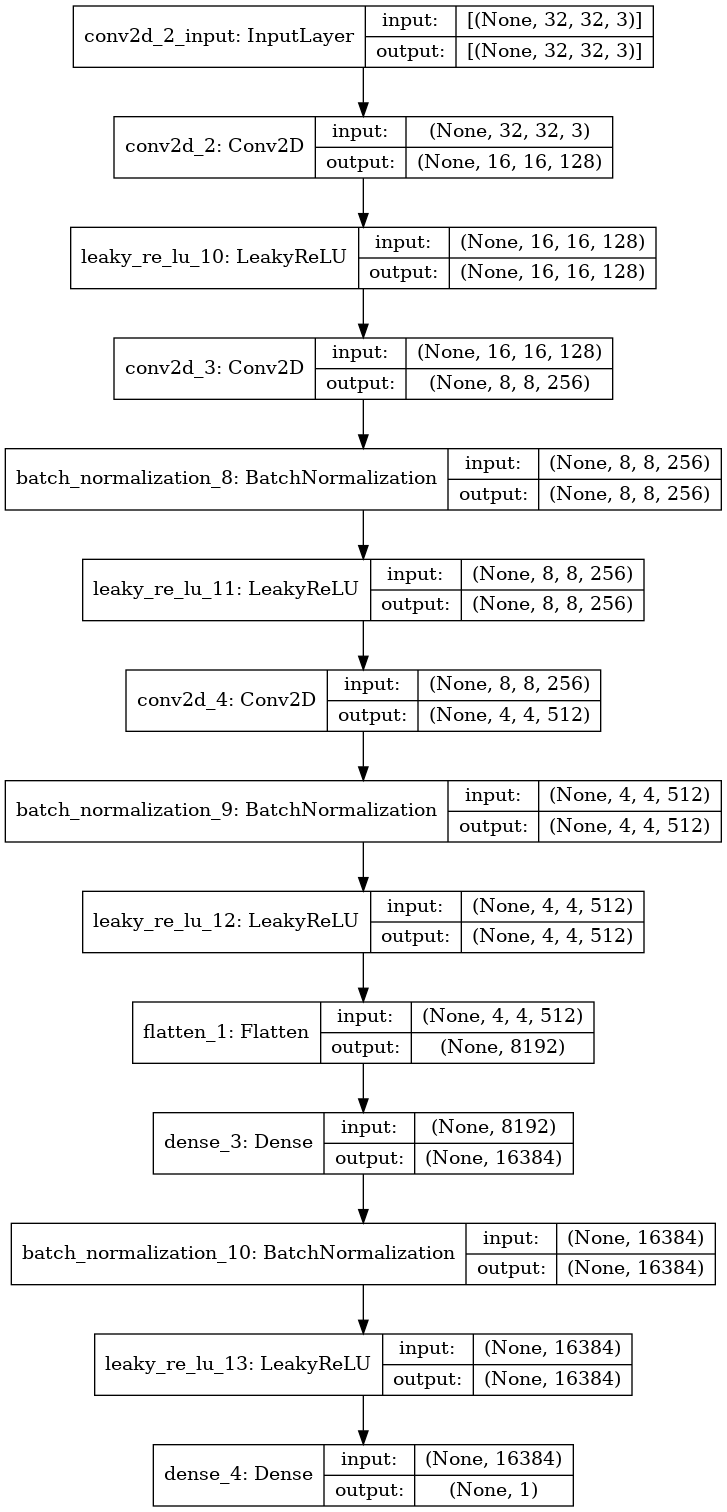

In [37]:
# make_discriminator_model 함수로 구현
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth : Flatten Layer # 1차원으로 펴는 작업
    model.add(layers.Flatten())
    
    # Fifth: Dense Layer
    model.add(layers.Dense(4 * 4 * 1024, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1))
    return model

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로,  
판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다.

첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는,  
다음 층을 거치며 (16, 16, 128) → (8, 8, 256) → (4, 4, 512)까지 줄어들게 된다.

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서, 4 * 4 * 512 = 8192
즉 (1, 8192) 형상의 벡터로 변환한다. 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 반대 역할이다.

1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력한다.

In [38]:
# 모델 세부내용 출력
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 512)         3277312   
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 4, 512)        

## 필요 함수 구현

모델 학습에 필요한 함수를 구현한다.
1. 손실함수(loss function)
    - 교차 엔트로피(Cross Entropy)
    
    
2. 최적화함수(optimizer)
    - Adam


3. 학습과정

### 1. 손실함수 (loss function)


딥러닝 모델이 학습하기 위해 꼭 필요한 두가지는 손실함수(loss function)와 최적화 함수(optimizer)이다.

<br>
GAN은 손실함수로 분류 모델시 많이 사용하는 교차 엔트로피(Cross Entropy)를 사용한다.

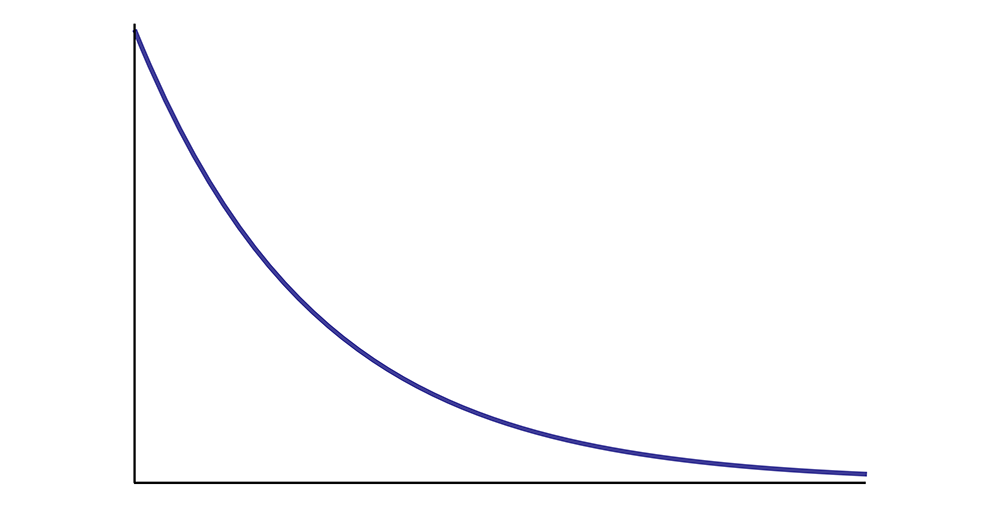
<center> 교차 엔트로피 (cross entropy) </center>

교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있으며, 점점 가까워 지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산하는데 많이 쓰인다. 

<br>
오늘 모델에서의 판별자는 한개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용한다.
<br><br>
Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 한다면,

1. 생성자의 목표는 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것이고,

2. 판별자의 목표는 Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것이다.

다만 판별자 모델의 맨 마지막 Layer에는 값을 정규화 시키는 simoid나 tanh같은 활성화 함수가 없었다. 즉 구분자가 출력하는 값은 범위가 정해져있지 않아서 모든 실수값을 가질 수 있다.

또한 tf.keras의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정하기 때문에, from_logits를 True로 설정해주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid를 사용하여 0-1 로 정규화 한 후 알맞게 계산할 수 있다.

In [39]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.

fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

위 두가지를 1과 0으로 비교를 하기위해, 
아래와 같이 tf.ones_like()와 tf.zeros_like() 함수를 사용한다.
이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용한다.

In [40]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

### generator_loss

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 된다. 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [41]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
discriminator_loss는 real_output 값은 1에 가까워지기를, 
fake_output 값은 0에 가까워지기를 바라므로, 
두 가지 loss값을 모두 계산한다.
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 알수 있다.
최종 discriminator_loss 값은 이 둘을 더한 값이다.

In [42]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다. 

그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.

In [43]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면,

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 일때,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])

(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])

(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5


### 2. 최적화 함수(optimizer)

최적화 함수로는 Adam 을 활용한다. Adam 함수 또한 tf.keras.optimizers 안에 있다. 중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해봐야 한다. 그리고 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다.

In [44]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인한다. 샘플은 한 번에 16장을 생성하고, 계속 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 한다.

여기선 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만든다.

In [45]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 3. 훈련을 위한 코드 설계

하나의 미니 배치 당 진행할 train_step 함수를 만들어야 한다. 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙이면, 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있다.


- 데코레이터 참고 자료 : <br>
https://bluese05.tistory.com/30 <br>
https://www.tensorflow.org/api_docs/python/tf/function

### train_step 함수

(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음 <br>
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함 <br>
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기 <br>
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성 <br>
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력 <br>
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산 <br>
(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산 <br>
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산 <br>
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신 <br>
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴 <br>



In [46]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 생성자 출력물 시각화 함수 

다음엔 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만든다.<br>
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다.

In [47]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig(
        '/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it)
    )

    plt.show()

- model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정인데, 위에서 해봤던 subplot을 이용해서 총 16개의 sample을 시각화하는 과정이다. 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화하는 것이다.

- 또한, plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장한다.

- 학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프가 있다. GAN의 학습 과정은 두 모델이 서로의 학습 과정에 영향을 주고받는다. 

- train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만든다. 

- 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리한다.

### 정확도 변화 시각화 및 저장함수
학습 과정 중 변화하는 손실값과 정확도를 시각화 및 저장하는 함수를 생성한다.

In [48]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    plt.subplots_adjust(hspace=0.45)
    
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'], alpha=0.5)  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'], alpha=0.5)  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(
        '/aiffel/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'.format(epoch)
    )
    plt.show()

## 모델 학습

1. train_step 한 단계를 학습  

2. generate_and_save_images() 샘플 이미지를 생성하고 저장  

3. draw_train_history() 학습 과정 시각화  

4. checkpoint 모델과 가중치 저장  


이제까지 만든것을 하나의 모델로 합치겠습니다.

In [49]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### checkpoint 함수

다음엔 정기적으로 모델을 저장하기 위한 checkpoint를 만든다. tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다. checkpoint에는 optimizer, 생성자와 판별자가 학습한 모델 가중치를 저장한다. checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용한다.

In [50]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 학습 하이퍼 파라미터
- save_every : 모델을 저장하는 간격
- EPOCHS : 전체 학습 에포크

In [53]:
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")
save_every = 10
EPOCHS = 12

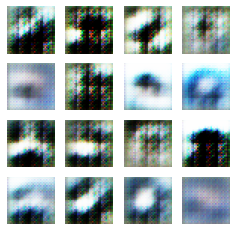

Time for training : 4560 sec


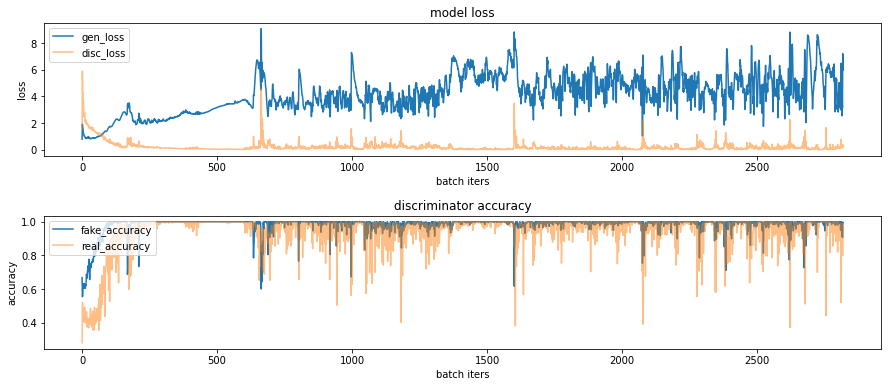

CPU times: user 54min 9s, sys: 21min 34s, total: 1h 15min 44s
Wall time: 1h 16min 1s


In [54]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해보기

~/aiffel/dcgan_newimage/fashion/ 폴더 경로에 fashion_mnist_dcgan.gif를 클릭하면 
생성자가 만들어내는 이미지의 품질이 점점 개선되어 가는 과정을 한눈에 볼 수 있다.

### 학습과정 시각화

학습이 끝난 후 imageio 라이브러리를 활용해서 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일로 만든다. imageio.get_writer를 활용해서 파일을 열고, append_data로 이미지를 하나씩 붙여나가는 방식으로 만들어진다. fasion_mnist_dcgan.gif 파일로 저장된다.

In [17]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 983033 Nov 21 22:41 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


### 결과물

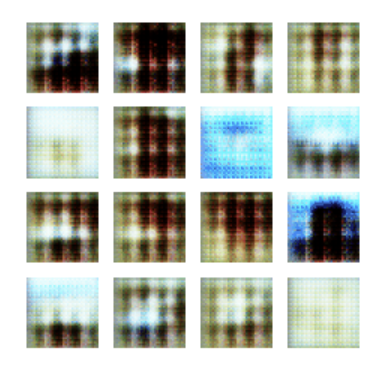

https://8888-wo0atymulazmnwnlpdfiluwh7.c2.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

(gif 삽입이 안되어 링크 첨부합니다.)

### 결론

오랜시간 돌렸으나 지속적인 오류가 발생하여, EPOCH를 적게 잡고 돌렸다. 맨 오른쪽 3번째 사진에 어떠한 형체를 제외하고는 점점 이미지가 뭉그러지며 뚜렷한 이미지가 나오지는 않았다. 만족스러운 결과가 나오지 않아 아쉽지만, 다른 방법을 찾아보았는데 먼저 GPU파워가 있다면 200이상 EPOCH를 돌려서 확인해보고 싶다. 파워와 시간관계로 더 많은 EPOCH를 돌려보지 못한것이 가장 아쉽다.

외적으로 좀더 확실한 이미지를 얻을 수 있는 방법을 찾아보았고, 육안으로 구분하기에 가장 좋은이미지를 얻는방법은 옵티마이져를 조정하는 것이었다. 생성자는 빠르게 만들어 많은 시도를 할수 있도록 학습률을 증가시키고, 판별자는 꼼꼼히 학습을 할 수 있도록 학습률을 낮추는 방법이다. 두 학습률을 조율하여 전체적인 학습시간이 너무 커지지 않도록 한다.

이후에 예제를 진행할때 위 방법으로 시도해 본다면 좀더 나은 결과물을 얻을수 있지 않을까 싶다.